# 多腕バンデッド問題


確率p で 1 を、1-p で 0 を返すスロットマシンを考えます。（このような分布をベルヌーイ分布といいます。）
そのようなスロットマシンが10 台あるとします。ただし、それぞれの p は分からないとします。
スロットマシンを合計 10000 回引くチャンスが与えられたとして，できるだけ高い得点を得る思考ルーチンを作成しましょう。

この多腕バンディット問題は、ジレンマを抱えた問題です。いろんなスロットマシンを引いてみないと、どれがいいスロットマシンか分かりません。いいスロットマシンだと思ったら、それを優先的に引くべきですが、今までの結果がたまたまかもしれないので、今まで調子が悪かったらといって、全く顧みないのでは良くないです。最初は，どれの確率が高いか分からないので，プレーしながら勉強していくしかありません。

全体の回数は 10000 回としましたが，この値によって，戦略は違ってくるでしょう。
また，p の値は分からなくても，その分布に関する情報があると状況が変わってきます。
例えば，p の値は 1 か 0 しかとらないということが分かっていれば，一度当たったのはずっと引き続ければいいし，一度外れたものをもう一度引くことはないというのが戦略となるでしょう。
ここでは，p の分布は [0, 1] の一様分布 (random.uniform(0,1) で与えられるもの) とします。

Bandit はスロットマシンのクラス(p というインスタンス変数に確率をもっています)で，slot という無引数のメソッドをもっています(これは，ユーザは直接アクセスしません)。
MultiArmedBandit はそのようなスロットマシン 10 台集まったもの（多腕バンデット）のクラス( bandits というインスタンス変数 Bandit のリストを持っています)で，slot というスロットマシンの番号を引数としてとるメソッドをもっています（ユーザーはこれを呼び出します）。update は，今は使いません。


In [152]:
import random
class Bandit:
    '''スロットマシン  確率 p で  1, 1-p で 0 を返す （ベルヌーイ分布）
         インスタンス変数：p   ランダムに [0, 1] の値が設定されている。
         メソッド：
            slot() スロットを引く。確率 p で  1, 1-p で 0 が返ってくる。
    '''
    def __init__(self):
        self.p = random.uniform(0,1)

    def slot(self):
        if (random.uniform(0,1) <  self.p):
            return 1
        else:
            return 0

    def update(self):
        '''1/2 の確率で，0.05 上げるか下げるか。 今は使用しない。\
        0 または 1 になったらそれ以上は動かさない。'''
        if(random.uniform(0,1) < 0.5):
            self.p = max(self.p - 0.05, 0)
        else:
            self.p = min(self.p + 0.05, 1)

class MultiArmedBandit:
    '''スロットマシンを10個まとめたもの
         クラス変数：NUM  3 (定数)
         インスタンス変数：bandits スロットマシンのリスト
         メソッド：
            slot(i) i 番目のスロットを引く。
            getmax() スロットマシンの確率の最大値を返す。
    '''
    NUM= 3;   #スロットマシンの個数
    def __init__(self):
        self.bandits = [Bandit() for i in range(MultiArmedBandit.NUM)]

    def slot(self,i):
        '''i 番目のスロットマシンを引く'''
        if (i < 0 or i >= MultiArmedBandit.NUM):
            return 0
        return self.bandits[i].slot()

    def update(self):
        '''全ての確率を更新。今は使用しない。'''
        for b in self.bandits:
            b.update()

    def getmax(self):
        return max([x.p for x in self.bandits])


MultiArmedBandit を一つ作って，m に代入します。

In [153]:
m = MultiArmedBandit()

各スロットマシンの確率は，次のようにして見ることができます。ただし，これを見るのは実験段階では構いませんが，思考ルーチンで，これを使ったプログラムを書いてはいけません。

In [154]:
print([f"{x.p:5.5f}" for x in m.bandits])

['0.53007', '0.72957', '0.39194']


In [155]:
m.slot(1)

1

1 回づつ引いてみましょう。

In [156]:
for i in range(10):
    print(m.slot(i))

1
1
1
0
0
0
0
0
0
0


思考ルーチンを作ることを考えます。思考ルーチンは，次の 3 つのメソッドからなるものとします。

choice():  次どれを引くか番号を返す。

learn(k, result): k を引いた結果 result だったということを学習する。

reset():  今までの学習結果を忘れて，最初から学習を行う。

この３つのメソッドを持つクラスを作りましょう。例えば，何も学習せずに，乱数を発生させて，ランダムに引くのは次のようなものです。


In [157]:
class RandomStrategy:
    ''' ランダムにスロットマシンを引く戦略
    '''
    def learn(self,k, result):
        return

    def choice(self):
        return random.randrange(MultiArmedBandit.NUM);

    def reset(self):
        return



In [158]:
s = RandomStrategy()

In [159]:
s.choice()

1

また，前にひいたのが当たったら，またそれを引く。そうでないときには，次のをひく（最後までいったら最初に戻る）というのは，次のようになります。


In [160]:
class TsuikiStrategy:
    ''' 前のが当たったらそれを引く戦略
    インスタンス変数:
        my : 次に引く手
    '''
    def __init__(self):
        self.my = 0
    def learn(self, k, result):
        if (result == 1):
            self.my = self.my;
        else:
            self.my = (self.my + 1)% MultiArmedBandit.NUM

    def choice(self):
        return self.my

    def reset(self):
        self.my = 0

In [161]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def MABTest(numplay, strategy, mab, change=False):
    '''引数：
    　　numplay : 回数
      　strategy : ストラテジー
        mab :  MultiArmedBandit
    
    mab から strategy に従って numplay 回引いて,
    それぞれ何回引いて何回当たったかをグラフ表示する'''
    total = [0]*MultiArmedBandit.NUM
    atari = [0]*MultiArmedBandit.NUM
    myaccount = 0
    for i in range(numplay):
        k = strategy.choice();   # strategy に聞いて
        result = mab.slot(k);   # 言われたスロットをひいて
        total[k] += 1
        atari[k] += result
        myaccount += result;    # 結果だけ account を増やす (0 か 1)
        strategy.learn(k,result);     #k を引いて結果が result だったことを str に学習させる
        if(change):
            mab.update()   # 確率を毎回変化させるには，change を true にする。
    print(f"{numplay} 中 {myaccount}回あたり")   

    fig, ax1 = plt.subplots()
# この行は，次の2行と同じ。
#    fig = plt.figure()
#    ax1 = fig.add_subplot(1,1,1)
 
    ax1.plot([x.p for x in mab.bandits], color="red", label="スロット確率")
    ax1.set_ylim(0,1)
    ax2 = ax1.twinx()  # 右目盛りと左目盛り
    ax2.plot(atari, label="当たり回数")
    ax2.plot(total, label="引いた回数")
    ax2.set_ylim(0,numplay)
    ax1.legend(loc='upper left', prop={"family":"MS Gothic"}) 
    ax2.legend(loc='upper right', prop={"family":"MS Gothic"})  
#        print([f"{x.p:2.2}" for x in m.bandits])
#    print([f"{atari[x]:4}" for x in range(10)])
#    print([f"{total[x]:4}" for x in range(10)])

100 中 23回あたり
100 中 22回あたり


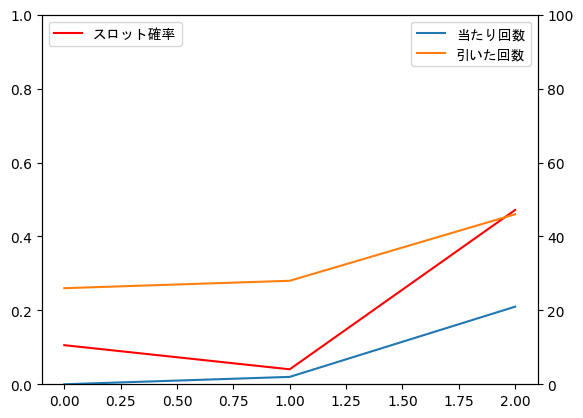

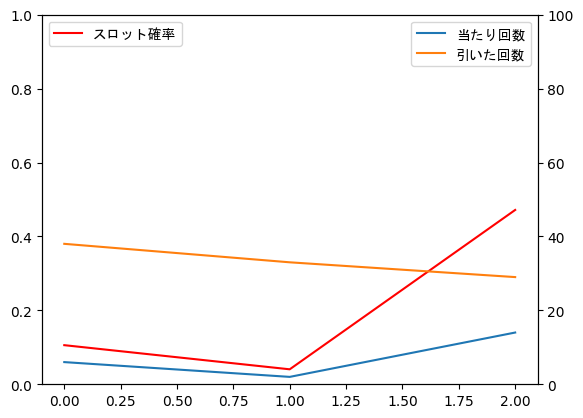

In [162]:
m = MultiArmedBandit()
s = TsuikiStrategy()
s1 = RandomStrategy()
MABTest(100, s, m)
MABTest(100, s1, m)


10000 中 8137回あたり
10000 中 7400回あたり
10000 中 9914回あたり
10000 中 6968回あたり
10000 中 3934回あたり


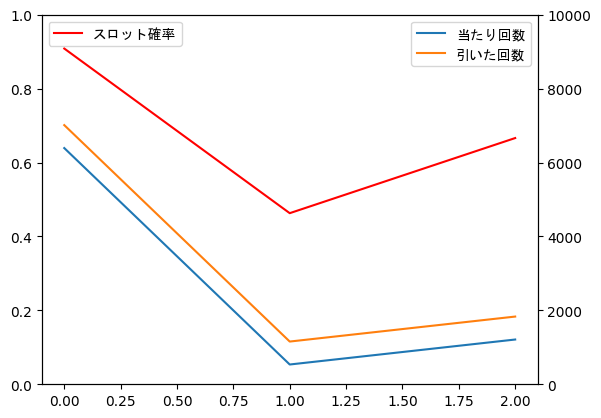

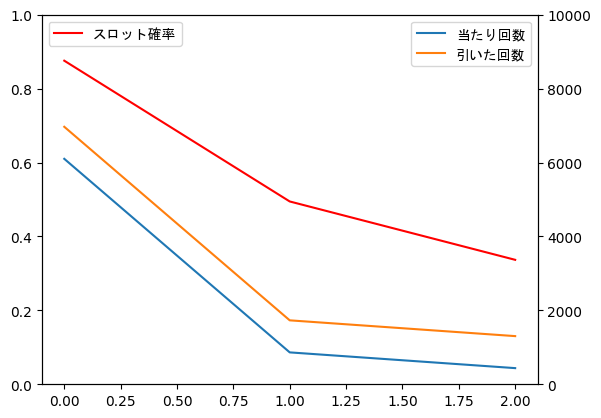

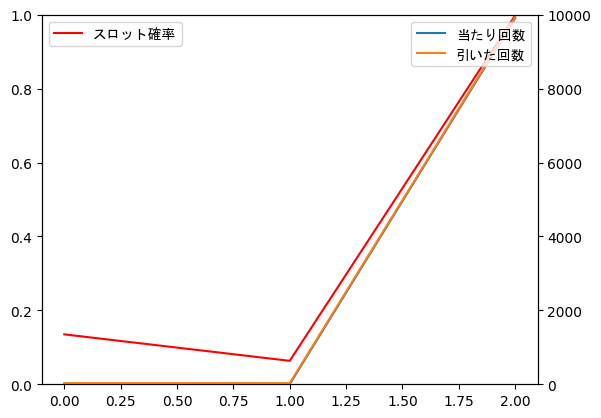

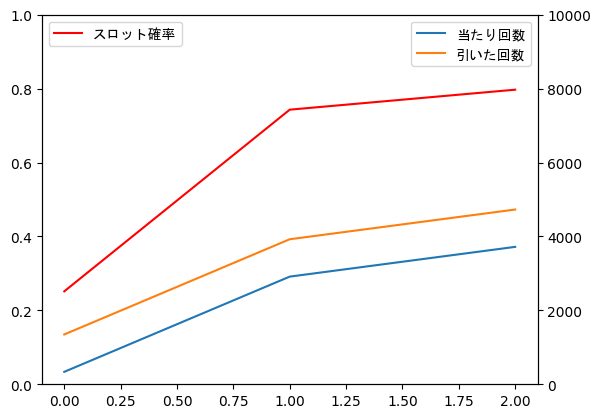

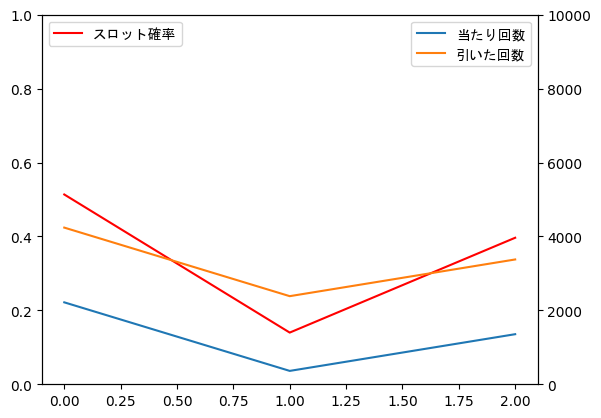

In [163]:
  
for i in range(5):
    MABTest(10000, TsuikiStrategy(), MultiArmedBandit()) 

**練習問題** コンスタントに同じ(例えば0 番)を引くという strategy を作り，RandomStrategy と TsuikiStrategy と３つの strategy を比較しよう。それぞれ，どのような性質を持っているか。それぞれ，どういう時に有効か。また，どういう目的の時にどの Strategy を使ったらよさそうか。


**練習問題** strategy の良さは，何を目標とするかで変わってくると考えられる。5 回の試行ではなく，1000回試行し，その結果の値の，最大の期待値（すなわち，一番確率のいいものばかりを引き続けた時の値）に対する当たり回数の比の平均と分散を計算しよう。また，その分布をグラフで視覚化しよう。

**練習問題** 自分の strategy を作ろう。それを，"自分の名前"+Strategy という名前のクラスにし，
自分の名前.py というファイルに作ろう。それを，来週までに PandA の課題に提出すること。来週，strategy の競争を行う。
次回（12 回）のプリントや，ネットから得られる情報は見ないで，自分で考えよう。

以下は，来週，競争に使うプログラム。100 回引くのを１プレイとして，同じ MAB に対してプレイした時の当たった確率で，何回か(次の例では200 回)競う。

In [164]:
import numpy as np

def OnePlay(numplay, strategies, mab, change=False):
    ''' strategies : 戦略のリスト
    結果は，それぞれの戦略での当たり確率を，ndarray として返す。'''
    myaccounts = np.zeros(len(strategies), dtype=int)
    for x in strategies:
        x.reset()

    for i in range(numplay):
        for s in range(len(strategies)):
            k = strategies[s].choice() 
            result = mab.slot(k)   
            myaccounts[s] += result 
            strategies[s].learn(k,result)  
        if(change):
            mab.update()  # 確率が変化していく場合
    return(myaccounts/numplay)  

def MultiMABTester(n, strategies, change=False):
    NUMPLAY = 100
    ret = np.zeros((len(strategies),0))
    
    for i  in range(n):
        mab = MultiArmedBandit()
        ret = np.append(ret, OnePlay(NUMPLAY, strategies, mab, change).reshape(len(strategies),1), axis=1)
    return ret


[[0.15 0.7  0.48 0.83 0.6  0.76 0.93 0.83 0.95 0.48 0.41 0.62 0.64 0.66
  0.39 0.32 0.45 0.61 0.63 0.69 0.3  0.45 0.79 0.34 0.28 0.62 0.81 0.76
  0.56 0.27 0.56 0.69 0.33 0.98 0.68 0.77 0.73 0.47 0.59 0.82 0.21 0.93
  0.4  0.67 0.83 0.33 0.85 0.88 0.69 0.94 0.56 0.52 0.77 1.   0.87 0.99
  0.84 0.79 0.53 0.37 0.66 0.88 0.58 0.75 0.78 0.97 0.36 0.89 0.17 0.5
  0.67 0.55 0.41 0.39 0.78 0.82 0.68 0.72 0.73 0.4  0.39 0.97 0.81 0.96
  0.5  0.71 1.   0.77 0.57 0.84 0.86 1.   0.89 0.75 0.57 0.94 0.77 0.58
  0.37 0.45 0.83 0.58 0.84 1.   0.8  0.59 0.7  0.34 0.98 0.38 0.81 0.24
  0.78 0.42 0.82 0.44 0.86 0.94 0.1  0.88 0.86 0.86 0.47 0.61 0.58 0.29
  0.7  0.39 0.46 0.82 0.92 0.98 0.5  0.4  0.55 0.89 0.33 0.44 0.81 0.88
  0.41 0.48 0.41 0.82 0.76 0.88 0.78 0.86 0.69 0.85 0.31 0.5  0.34 0.68
  0.8  0.49 0.27 0.68 0.7  0.34 0.55 0.4  0.9  0.76 0.4  0.66 0.55 0.47
  0.86 0.93 0.65 0.86 0.54 0.96 0.68 1.   0.05 0.22 0.95 0.96 0.6  0.56
  0.92 0.41 0.89 0.55 0.48 0.31 0.16 0.47 0.6  0.66 0.57 0.75 0.9

[(0.6417499999999999, 'Tsuiki'), (0.49599999999999994, 'Random')]

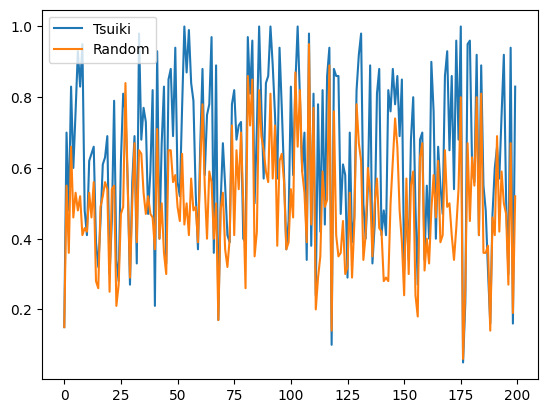

In [166]:
names = ["Tsuiki", "Random"]
numplay=200
ret = MultiMABTester(numplay, [TsuikiStrategy(),
                          RandomStrategy()
                         ])
print(ret)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
for i in range(len(names)):
    ax1.plot(ret[i], label=names[i])
ax1.legend(loc='upper left')
sorted(zip(map(lambda x: sum(x)/numplay,ret), names), reverse=True)

**練習問題** 上の MABTester, および，MultiMABTester に，change=True という引数を渡すと，毎回，全てのスロットの確率が 1/2 の確率で 0.05 づつ上がるか下がるかするようになる。
（ただし，確率が 0 より小さく，または大きくならない）
この設定のもとで，戦略プログラムを組んでみよう。


[(0.6620999999999999, 'Tsuiki'), (0.51395, 'Random')]

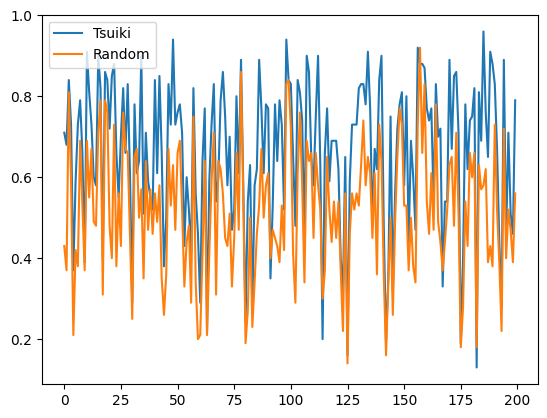

In [167]:
names = ["Tsuiki", "Random"]
numplay=200
ret = MultiMABTester(numplay, [TsuikiStrategy(),
                          RandomStrategy()
                         ], change=True)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
for i in range(len(names)):
    ax1.plot(ret[i], label=names[i])
ax1.legend(loc='upper left')
sorted(zip(map(lambda x: sum(x)/numplay,ret), names), reverse=True)

**練習問題** なぜ，安定的になったのか，考察しよう。ヒント：それぞれのスロットマシンの確率がどのように変化するのかグラフにしてみよう。